In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import jax.numpy as jnp
import numpyro
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
from jax import random,vmap,jit
import time
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', size=16,family='serif')
matplotlib.rc('legend', fontsize=16)


In [13]:
def cdist(x, y):
    # x, y are n1 x d and n2 x d
    # print(x.shape,y.shape)
    return jnp.sum(jnp.square(x[:,None,:] - y),axis=-1) 

@jit
def rbf_kernel(xa,
               xb,
               lengthscales,
               outputscale): # can use vmap for rbf/cdist? possibly faster in high dim or when large number of xa already accumulated
    c_dist = cdist(xa/lengthscales,xb/lengthscales) 
    c_dist = jnp.exp(-0.5*c_dist)
    return outputscale*c_dist

In [18]:
ndim = 1
train_x = np.random.uniform(0,1,5).reshape(-1, 1)
f_mean = 0.33
f_std = 0.2
f = lambda x: -0.5*(x-f_mean)**2 / f_std**2 #-0.5*25*jnp.cos(20*(x-0.5)**2)  # 
train_y = f(train_x)
noise = 1e-5

def model():
    outputscale = numpyro.sample("kernel_var", dist.Gamma(concentration=2.,rate=0.15))
    tausq = numpyro.sample("kernel_tausq", dist.HalfCauchy(0.1))
        # def trunc_HC(scale=tausq,low=None,high=None,validate_args=None):
        #         return dist.TruncatedDistribution(base_dist=dist.HalfCauchy(scale*jnp.ones(self.ndim)),
        #                                         low=low,
        #                                         high=high,
        #                                         validate_args=validate_args,)
    inv_length_sq = numpyro.sample("_kernel_inv_length_sq",dist.HalfCauchy(jnp.ones(ndim))) # type: ignore
        # inv_lengthscales = numpyro.sample("_kernel_inv_length_sq",trunc_HC(scale=tausq,low=0.1,high=100.))
    lengthscales = numpyro.deterministic("kernel_length",1/jnp.sqrt(tausq*inv_length_sq)) # type: ignore
    k = rbf_kernel(train_x,train_x,lengthscales,outputscale) + noise*jnp.eye(train_x.shape[0]) #self.train_yvar * jnp.eye(self.train_x.shape[0])
    mll = numpyro.sample(
                "Y",
                dist.MultivariateNormal(
                    loc=jnp.zeros(train_x.shape[0]), # type: ignore
                    covariance_matrix=k,
                ),
                obs=train_y.squeeze(-1),)

start = time.time()
kernel = NUTS(model,dense_mass=False,
                max_tree_depth=6)
mcmc = MCMC(kernel,num_warmup=512,
                num_samples=512,
                num_chains=1,
                progress_bar=True,
                thinning=8,)
seed=0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
mcmc.run(rng_key,extra_fields=("potential_energy",))
mcmc.print_summary(exclude_deterministic=False)
extras = mcmc.get_extra_fields()
print(f"\nMCMC elapsed time: {time.time() - start:.2f}s")

samples = mcmc.get_samples()
extras = mcmc.get_extra_fields()
samples["minus_log_prob"] = extras["potential_energy"]

sample: 100%|██████████| 512/512 [00:00<00:00, 709.15it/s, 31 steps of size 1.24e-01. acc. prob=0.93]


                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]     12.04     23.21      5.50      0.35     28.11     41.83      0.97
        kernel_length[0]      0.66      0.20      0.70      0.38      0.99     47.05      0.97
            kernel_tausq      1.68      4.18      0.38      0.05      3.68     29.06      1.00
              kernel_var     23.75     11.75     21.52      9.81     43.10     51.21      0.99

Number of divergences: 0

MCMC elapsed time: 0.82s


[Text(0.5, 0, 'lengthscale'), Text(0, 0.5, 'outputscale')]

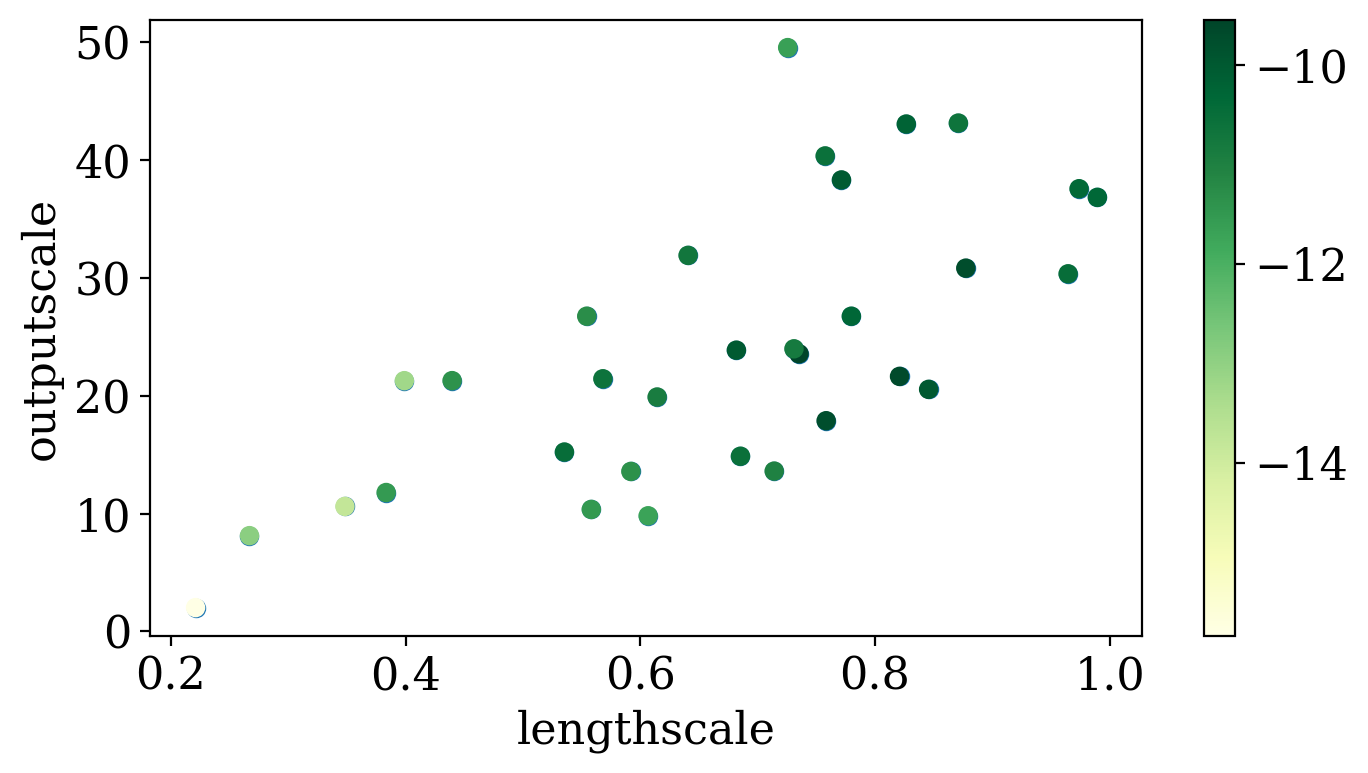

In [19]:
colors = matplotlib.colormaps['YlGn']

l = np.array(samples["kernel_length"].squeeze(-1))
o = np.array(samples["kernel_var"])
lp = -np.array(samples["minus_log_prob"])
lp_min, lp_max = np.min(lp), np.max(lp)
cols = np.linspace(lp_min,lp_max,len(lp))
cols = (cols - lp_min)/(lp_max - lp_min)


# print(np.shape(l),np.shape(o),np.shape(lp),np.shape(cols))
plt.figure(figsize=(8,4))
fig = plt.gcf()
ax = plt.gca()
ax.scatter(l,o)

# for i in range(0,len(lp)):
#     ax2.scatter(l[i],o[i],color=colors(cols[i])) 
sc = ax.scatter(l,o,c = lp, vmin = lp_min, vmax=lp_max,cmap= colors)
fig.colorbar(sc,ax=ax)
# ax2.colorbar()
ax.set(xlabel=r'lengthscale',ylabel=r'outputscale')

